# 2. EDA

# Prepare data - Jan 2015

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})
import contextily as ctx

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Function to retrieve data from postgis as geo df using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    con.close()
    return gdf

In [3]:
# Query to select 50,000 pickup data from January
q_jan = '''
        with
        
            jan as
            (
                select
                    tpep_pickup_datetime as pickup_time,
                    ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326) as pickup_point
                from taxi_jan
            )
        
        select jan.*
        from jan, census_blocks as census
        where ST_Contains(census.geometry, jan.pickup_point)
        LIMIT 50000;
        '''

# Save the query result as a geodataframe
pickup_jan = get_gdf(q_jan, 'pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-04 04:57:21,POINT (-73.95435 40.80396)
1,2015-01-04 04:57:22,POINT (-73.91936 40.76550)
2,2015-01-23 19:48:38,POINT (-74.00048 40.74276)
3,2015-01-23 19:48:38,POINT (-73.99213 40.74984)
4,2015-01-23 19:48:38,POINT (-73.98119 40.73083)


In [4]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   50000 non-null  datetime64[ns]
 1   pickup_point  50000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 781.4 KB


In [5]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(50000, 2)

In [6]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(49984, 2)

In [7]:
pickup_jan.pickup_time.dt.date.value_counts()

2015-01-07    2313
2015-01-17    2222
2015-01-13    2178
2015-01-23    2119
2015-01-24    2046
2015-01-14    2034
2015-01-16    1933
2015-01-08    1898
2015-01-01    1866
2015-01-21    1798
2015-01-28    1763
2015-01-11    1761
2015-01-10    1739
2015-01-30    1721
2015-01-06    1708
2015-01-31    1677
2015-01-19    1675
2015-01-15    1607
2015-01-18    1600
2015-01-29    1547
2015-01-12    1493
2015-01-25    1474
2015-01-20    1474
2015-01-22    1436
2015-01-05    1278
2015-01-04    1267
2015-01-09    1124
2015-01-02    1074
2015-01-26     936
2015-01-03     906
2015-01-27     317
Name: pickup_time, dtype: int64

In [8]:
# Print CRS
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [9]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [10]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {demographic.isnull().any().sum()}')
print(f'How many duplicated rows?: {demographic.duplicated().sum()}')

How many rows with missing values?: 0
How many duplicated rows?: 0


In [11]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [12]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [13]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [14]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

# Visualize the data

In [15]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

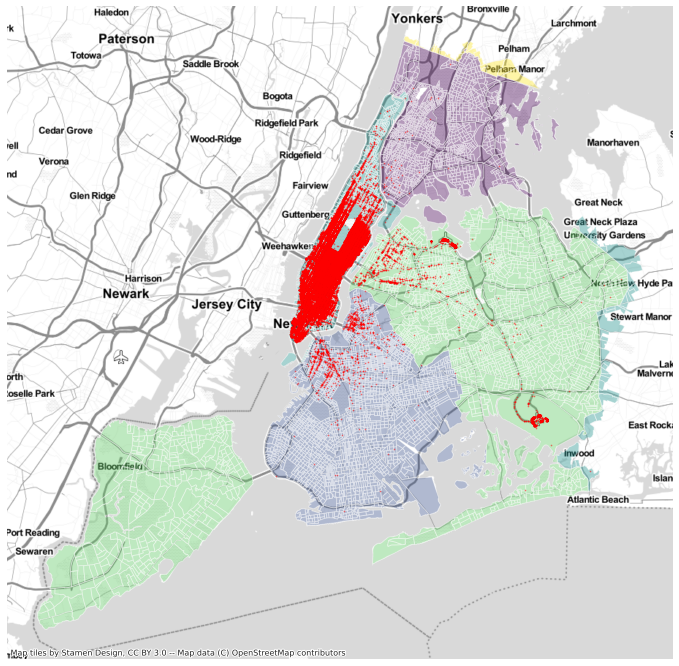

In [16]:
# Plot the census blocks
ax = census.plot(column = 'geoid', figsize=(12, 12), scheme='EqualInterval', alpha=.4, cmap='viridis')

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.4, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# Spatial join

In [74]:
# Spatial join
print(census.shape)
print(pickup_jan.shape)
pickup_blocks = gpd.sjoin(census, pickup_jan, how='inner', op='intersects')
print(pickup_blocks.shape)
pickup_blocks.head()

(6339, 2)
(49984, 2)
(49984, 4)


,geoid,geometry,index_right,pickup_time
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11
15,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37
15,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54


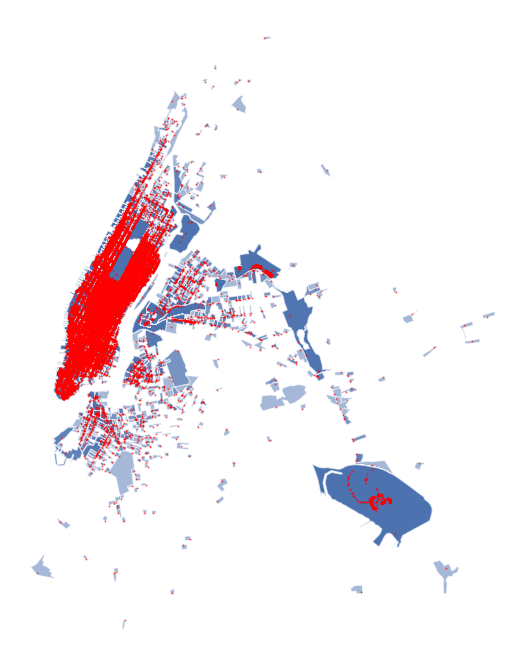

In [75]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(figsize=(15,12), alpha=.5)
pickup_jan.plot(ax=ax, color='red', alpha=.5, markersize=1)
ax.set_axis_off()
plt.show()

In [76]:
# Count how many pickups were made within each block
counted = pickup_blocks.geoid.value_counts()
counted = gpd.GeoDataFrame(counted).reset_index()
counted.columns = ['geoid', 'n_pickup']
counted.head()

,geoid,n_pickup
0,360610101001,1314
1,360810716001,948
2,360810331001,931
3,360610092001,785
4,360610099001,604


In [77]:
print(pickup_blocks.shape)
pickup_blocks = pickup_blocks.merge(counted, how='inner', on='geoid')
print(pickup_blocks.shape)
pickup_blocks.head()

(49984, 4)
(49984, 5)


,geoid,geometry,index_right,pickup_time,n_pickup
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2


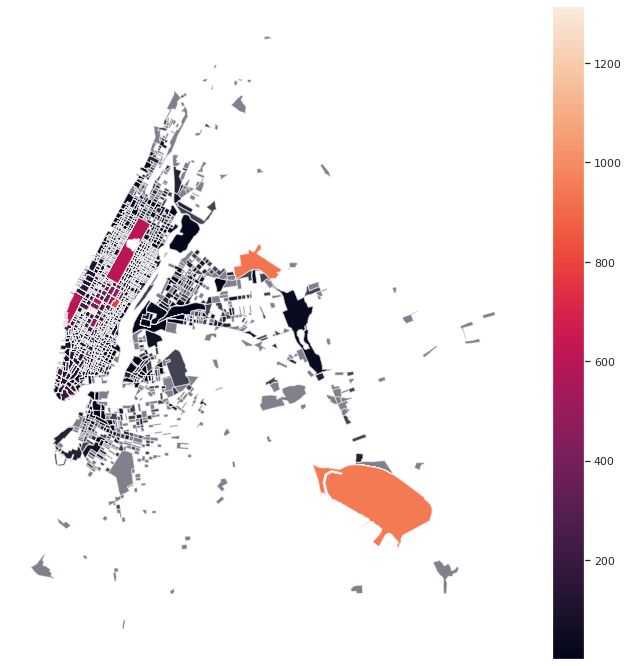

In [70]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(column='n_pickup', figsize=(12,12), alpha=.5, legend=True)
ax.set_axis_off()
plt.show()

* Get average pickups per area of each block
* Get average pickups per different date types

In [78]:
# Let's get average pickups per area of each block
# Check projected CRS is still 3857
print(pickup_blocks.crs)

epsg:3857


In [89]:
# Calculate area of each block group
print(pickup_blocks.shape)
area = pickup_blocks.set_index('geoid').area

# Remove duplicated rows
area = area[~area.duplicated()]

# Set geoid as col, not idx
area = pd.DataFrame(area, columns=['area']).reset_index()

# Join area to the pickup_blocks
pickup_blocks = pickup_blocks.merge(area, how='inner', on='geoid', copy=False)
print(pickup_blocks.shape)

(49984, 5)
(49984, 6)


In [90]:
# Print the first rows of pickup_blocks
pickup_blocks.head()

,geoid,geometry,index_right,pickup_time,n_pickup,area
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3,4.477405e+05
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3,4.477405e+05
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3,4.477405e+05
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2,1.448064e+06
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2,1.448064e+06


In [106]:
pickup_blocks['n_pickup_per_area'] = pickup_blocks['n_pickup'] / pickup_blocks['area']
pickup_blocks.head()

,geoid,geometry,index_right,pickup_time,n_pickup,area,n_pickup_per_area
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3,4.477405e+05,0.000007
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3,4.477405e+05,0.000007
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3,4.477405e+05,0.000007
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2,1.448064e+06,0.000001
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2,1.448064e+06,0.000001


In [116]:
pickup_blocks['n_pickup_per_area'].idxmax()

23664

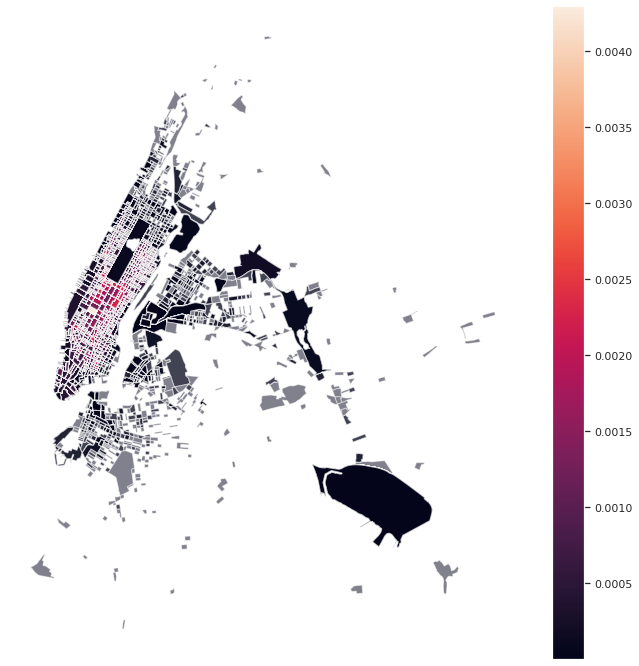

In [107]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(column='n_pickup_per_area', figsize=(12,12), alpha=.5, legend=True)
ax.set_axis_off()
plt.show()

### Look at the population of the block groups

In [111]:
# Get demographic & socioeconomic dataset

# Pivot the original table for convinience
demographic = demographic.pivot_table(values='value',
                                      index='geoid',
                                      columns='acs_demog_var')
# Reset index
demographic.reset_index(inplace=True)

print(demographic.shape)
demographic.head()

(6339, 34)


acs_demog_var,geoid,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
0,360050001001,NaN,25.0,125.0,3984.0,0.0,0.0,0.0,0.0,0.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
1,360050002001,NaN,0.0,0.0,468.0,608.0,271.0,608.0,63.0,356.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
2,360050002002,NaN,0.0,0.0,238.0,579.0,161.0,588.0,96.0,363.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
3,360050002003,NaN,0.0,104.0,202.0,382.0,108.0,382.0,33.0,239.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
4,360050004001,NaN,0.0,24.0,24.0,213.0,69.0,259.0,0.0,136.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [113]:
# Get total population of each block
total_pop = demographic[['geoid', 'total_pop']]

# Join area to the pickup_blocks
print(pickup_blocks.shape)
pickup_blocks = pickup_blocks.merge(total_pop, how='inner', on='geoid', copy=False)
print(pickup_blocks.shape)

(49984, 7)
(49984, 8)


In [117]:
pickup_blocks['total_pop'].idxmax()

47436

<AxesSubplot:>

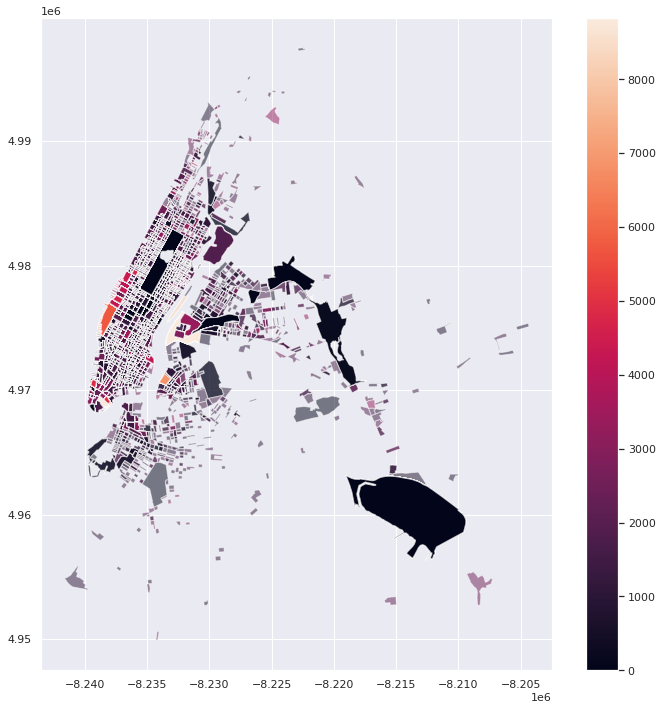

In [115]:
# Plot 
pickup_blocks.plot(column='total_pop', figsize=(12,12), alpha=.5, legend=True)

### Feature Engineering

In [118]:
# Prepare columns regarding calendar data
pickup_blocks['month'] = pickup_blocks['pickup_time'].dt.month
pickup_blocks['weekday'] = pickup_blocks['pickup_time'].dt.weekday
pickup_blocks['week'] = pickup_blocks['pickup_time'].dt.week
pickup_blocks['day'] = pickup_blocks['pickup_time'].dt.day
pickup_blocks['hour'] = pickup_blocks['pickup_time'].dt.hour
pickup_blocks.head()

<ipython-input-118-1fc8661f5c38>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pickup_blocks['week'] = pickup_blocks['pickup_time'].dt.week


,geoid,geometry,index_right,pickup_time,n_pickup,area,n_pickup_per_area,total_pop,weekday,week,day
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3,4.477405e+05,0.000007,1702.0,6,4,25
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3,4.477405e+05,0.000007,1702.0,6,1,4
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3,4.477405e+05,0.000007,1702.0,0,4,19
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2,1.448064e+06,0.000001,0.0,3,3,15
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2,1.448064e+06,0.000001,0.0,3,4,22


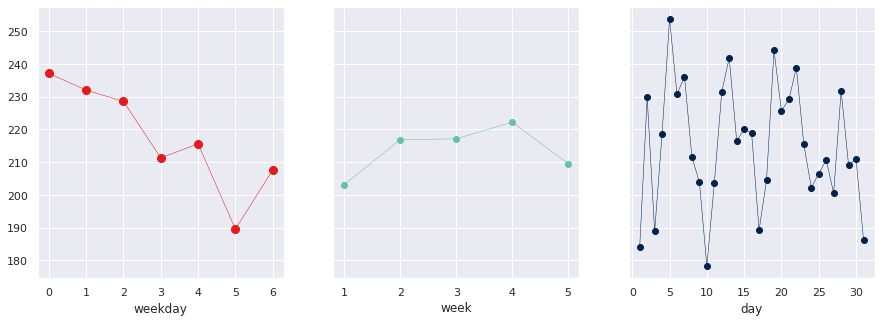

In [122]:
# Average pickups per weekdays & day of month
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

pickup_blocks.groupby('weekday')['n_pickup'].mean().plot(cmap='Set1',
                                                    marker='o',
                                                    markersize=8,
                                                    linewidth=0.5,
                                                    ax=ax[0])

pickup_blocks.groupby('week')['n_pickup'].mean().plot(cmap='Set2',
                                                marker='o',
                                                markersize=6,
                                                linewidth=.5,
                                                ax=ax[1])

pickup_blocks.groupby('day')['n_pickup'].mean().plot(cmap='cividis',
                                                marker='o',
                                                markersize=6,
                                                linewidth=.5,
                                                ax=ax[2])
plt.show()

In [123]:
pickup_blocks.head()

,geoid,geometry,index_right,pickup_time,n_pickup,area,n_pickup_per_area,total_pop,weekday,week,day
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3,4.477405e+05,0.000007,1702.0,6,4,25
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3,4.477405e+05,0.000007,1702.0,6,1,4
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3,4.477405e+05,0.000007,1702.0,0,4,19
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2,1.448064e+06,0.000001,0.0,3,3,15
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2,1.448064e+06,0.000001,0.0,3,4,22


# Merge the data

In [213]:
# Select the rest of the ACS dataset
rest_dmog_columns = [col for col in demographic.columns if col != 'total_pop']
demographic_rest = demographic[rest_dmog_columns]

# Merge all data
print(pickup_blocks.shape)
NY_df = pickup_blocks.merge(demographic_rest, on='geoid')
print(NY_df.shape)

NY_df.head()

(49984, 11)
(49984, 43)


,geoid,geometry,index_right,pickup_time,n_pickup,area,n_pickup_per_area,total_pop,weekday,week,...,occupied_housing_units,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
0,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",24542,2015-01-25 15:37:42,3,4.477405e+05,0.000007,1702.0,6,4,...,713.0,12.0,NaN,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",999,2015-01-04 03:38:07,3,4.477405e+05,0.000007,1702.0,6,1,...,713.0,12.0,NaN,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",43252,2015-01-19 00:42:11,3,4.477405e+05,0.000007,1702.0,0,4,...,713.0,12.0,NaN,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
3,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",18645,2015-01-15 14:06:37,2,1.448064e+06,0.000001,0.0,3,3,...,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
4,360050019004,"POLYGON ((-8229979.753 4983945.901, -8229895.1...",46744,2015-01-22 17:03:54,2,1.448064e+06,0.000001,0.0,3,4,...,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


# Modeling (baseline)

In [ ]:
# linear regression

In [ ]:
# variable distribution

NY_df

<AxesSubplot:>

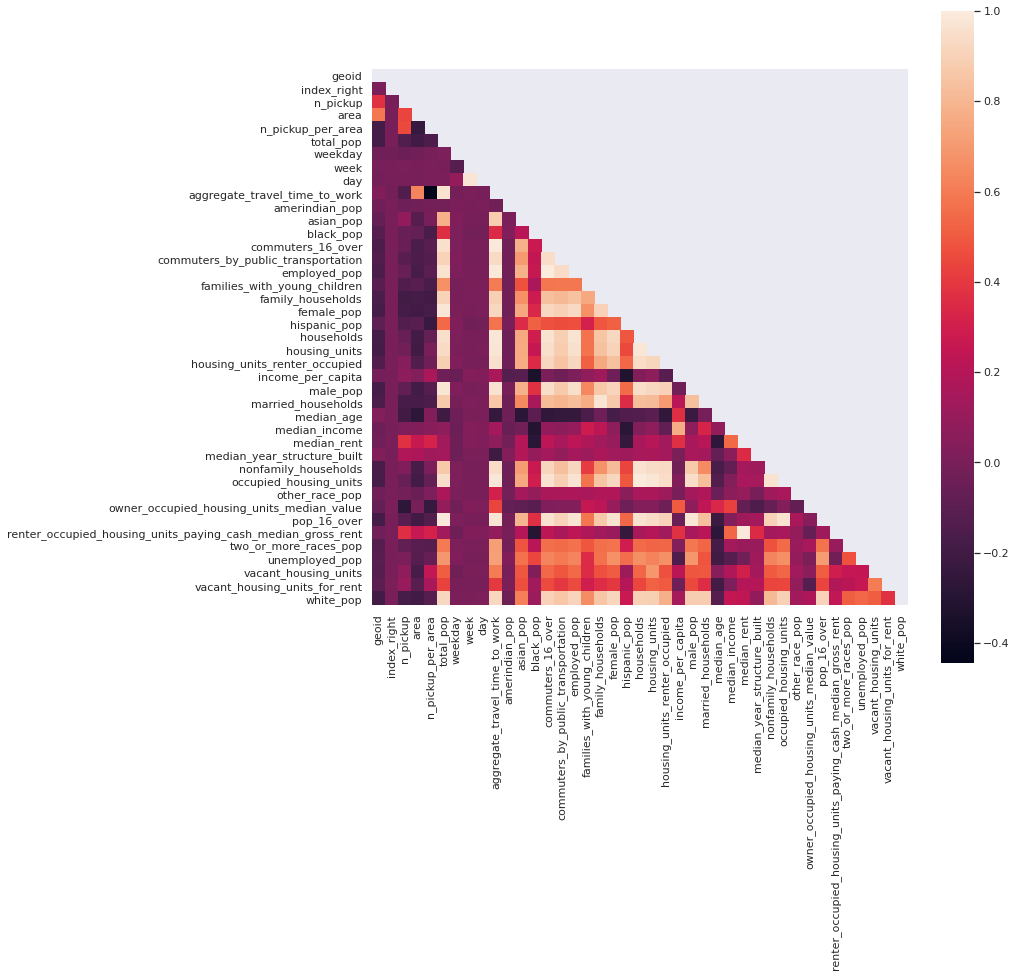

In [214]:
# Linear correlation
# Redifine the dataframe without geometry attribute
cols = [col for col in NY_df.columns if col not in ['geometry', 'pickup_time']]
NY_df = NY_df[cols]

# Calculate correlation coeff
corr = NY_df.corr()

# Confusion matrix
plt.figure(figsize=(12,12))
matrix = np.triu(corr)
sns.heatmap(corr, fmt='.1g', square=True, mask=matrix)

In [205]:
corr['n_pickup'].sort_values()

owner_occupied_housing_units_median_value                     -0.271336
median_age                                                    -0.192916
family_households                                             -0.189100
female_pop                                                    -0.183423
white_pop                                                     -0.174398
married_households                                            -0.169126
families_with_young_children                                  -0.144435
aggregate_travel_time_to_work                                 -0.143374
hispanic_pop                                                  -0.137198
total_pop                                                     -0.136614
pop_16_over                                                   -0.115342
commuters_by_public_transportation                            -0.106578
male_pop                                                      -0.082588
two_or_more_races_pop                                         -0

In [206]:
# Are all columns numeric?
NY_df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [215]:
# Any null values?
NY_df.isnull().sum()

geoid                                                              0
index_right                                                        0
n_pickup                                                           0
area                                                               0
n_pickup_per_area                                                  0
total_pop                                                          0
weekday                                                            0
week                                                               0
day                                                                0
aggregate_travel_time_to_work                                  41457
amerindian_pop                                                     0
asian_pop                                                          0
black_pop                                                          0
commuters_16_over                                                  0
commuters_by_public_transportation

In [217]:
# Impute missing data using most_frequent values since this is just a baseline model
from sklearn.impute import SimpleImputer

# Impute missing values
my_imputer = SimpleImputer(strategy='most_frequent')
NY_df = pd.DataFrame(my_imputer.fit_transform(NY_df),
                     columns = NY_df.columns)

In [218]:
NY_df.head()

,geoid,index_right,n_pickup,area,n_pickup_per_area,total_pop,weekday,week,day,aggregate_travel_time_to_work,...,occupied_housing_units,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
0,3.600500e+11,24542.0,3.0,4.477405e+05,0.000007,1702.0,6.0,4.0,25.0,35695.0,...,713.0,12.0,2000001.0,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
1,3.600500e+11,999.0,3.0,4.477405e+05,0.000007,1702.0,6.0,1.0,4.0,35695.0,...,713.0,12.0,2000001.0,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
2,3.600500e+11,43252.0,3.0,4.477405e+05,0.000007,1702.0,0.0,4.0,19.0,35695.0,...,713.0,12.0,2000001.0,1255.0,1260.0,35.0,90.0,43.0,21.0,163.0
3,3.600500e+11,18645.0,2.0,1.448064e+06,0.000001,0.0,3.0,3.0,15.0,22370.0,...,0.0,0.0,2000001.0,0.0,3501.0,0.0,0.0,0.0,0.0,0.0
4,3.600500e+11,46744.0,2.0,1.448064e+06,0.000001,0.0,3.0,4.0,22.0,22370.0,...,0.0,0.0,2000001.0,0.0,3501.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# add more data from apr & jul

In [219]:
target = 'n_pickup'
features = [col for col in NY_df.columns if col != target]

In [220]:
# train_test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(NY_df[features], # X
                                                    NY_df[target], # y
                                                    test_size=0.3,
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34988, 40)
(14996, 40)
(34988,)
(14996,)


In [221]:
# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [222]:
from sklearn.metrics import mean_absolute_error

In [223]:
# test
fitted_values = pd.DataFrame({
    'prediction': lr.predict(X_train)
}, index=X_train.index)

mae_in_sample = mean_absolute_error(y_train, fitted_values)
print(f'Mean absolute error in-sample: {mae_in_sample}')

Mean absolute error in-sample: 119.17578314129982


<AxesSubplot:>

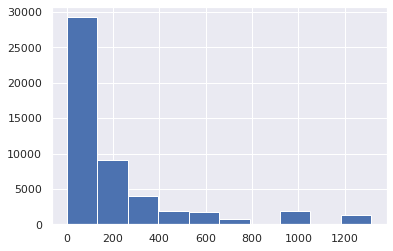

In [224]:
NY_df.n_pickup.hist()